### SIRSDE example

In [1]:
from functools import partial
from flowjax.train import fit_to_key_based_loss
from spyrox.train import ProgramToProgramSamplesLoss
from pyrox.program import SetKwargs

import jax
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from functools import partial
import jax.numpy as jnp
from spyrox.train import rounds_based_snle# , continuous_training
from spyrox.sirsde import SIRSDEGuide, SIRSDEModel
import equinox as eqx

from pyrox.losses import SoftContrastiveEstimationLoss

### Define the model

In [2]:
key, subkey = jr.split(jr.key(0))
model = SIRSDEModel(subkey)

key, subkey = jr.split(key)
guide = SIRSDEGuide(subkey)

### Generate toy data

In [3]:
# simulated obs
key, subkey = jr.split(key)
true_latents = eqx.filter_jit(model.sample)(subkey, use_surrogate=False)
[print(k, v.shape) for k, v in true_latents.items()]
obs = true_latents.pop("x")

global_means (4,)
infection_rate (5,)
infection_rate_mean ()
r0_mean_reversion (5,)
r0_mean_reversion_mean ()
r0_volatility (5,)
r0_volatility_mean ()
recovery_rate (5,)
recovery_rate_mean ()
x (5, 3)
z (5, 4)


### Prefit guide to prior

In [4]:
key, subkey = jr.split(key)
prior = SetKwargs(model.get_prior(observed_sites=("x",)), use_surrogate=False)
guide = SetKwargs(guide, obs=obs)
model = SetKwargs(model, obs=obs)

optimizer = optax.apply_if_finite(
    optax.chain(
        optax.adam(8e-4),
        optax.clip_by_global_norm(5),
    ),
    100,
)
guide, losses = fit_to_key_based_loss(
    subkey,
    guide,
    loss_fn=ProgramToProgramSamplesLoss(program_to_sample=prior),
    optimizer=optimizer,
    steps=1000,
    )

# This gives reasonable loss values (similar to prior entropy)
# Dependencies can be introduced in hierarchical priors, important to see these
# are modelled reasonably.


100%|██████████| 1000/1000 [01:06<00:00, 15.01it/s, loss=-16]    


### Fit posterior

In [7]:
key, subkey = jr.split(key)

surrogate_fit_kwargs = {
    "optimizer": optax.apply_if_finite(optax.adam(8e-4), max_consecutive_errors=10),
    "max_epochs": 10,
    "max_patience": 8,
    "batch_size": 40,
}

guide_fit_kwargs = {
    "optimizer": optax.apply_if_finite(optax.adam(8e-4), max_consecutive_errors=10),
    "loss_fn": partial(
        SoftContrastiveEstimationLoss(n_particles=2, alpha=0.75),
        ),
    "steps": 10000,
}

optimizer = optax.apply_if_finite(optax.adam(1e-4), max_consecutive_errors=10)

(model, guide), losses =  rounds_based_snle(
    key=subkey,
    model=model,
    guide=guide,
    num_rounds=2,
    sim_per_round=1000,
    simulator_param_name="z",
    surrogate_fit_kwargs=surrogate_fit_kwargs,
    guide_fit_kwargs=guide_fit_kwargs,
)

# key=subkey,
# model=model,
# guide=guide,
# steps=5,
# obs=obs,
# surrogate_optimizer=optimizer,
# vi_optimizer=optimizer,
# simulator_param_name="z",
# obs_name= "x",
# show_progress=False,

# TODO why is VI loss not

# Incompatibility between likelihood and guide?
# Fit guide to prior first? Then always use guide as proposal?



100%|██████████| 10000/10000 [06:19<00:00, 26.33it/s, loss=1.38]   


In [5]:
# Why are the losses so similar on the second round?

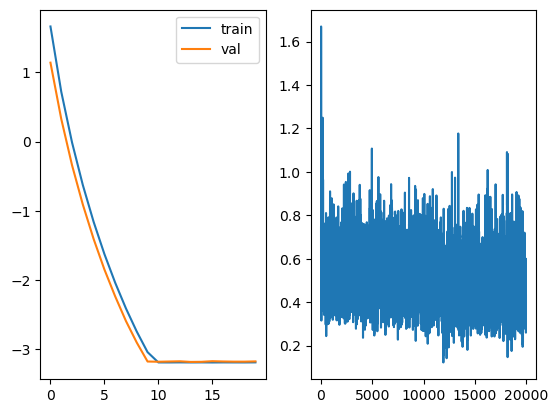

In [8]:
fig, axes = plt.subplots(ncols=2)

for k, loss_vals_round in losses["surrogate"].items():
    vals = [l for loss_vals in loss_vals_round for l in loss_vals]
    axes[0].plot(vals, label=k)
axes[0].legend()
axes[1].plot(
    jnp.convolve(jnp.asarray(losses["guide"]).ravel(), 0.1*jnp.ones(10), mode="valid"),
)


In [10]:
key, subkey = jr.split(key)
posterior = jax.jit(jax.vmap(guide.sample))(jr.split(key, 400))

key, subkey = jr.split(key)
joint_samples = jax.jit(jax.vmap(partial(model.sample, use_surrogate=False)))(
    jr.split(key, 400))


### Local inference

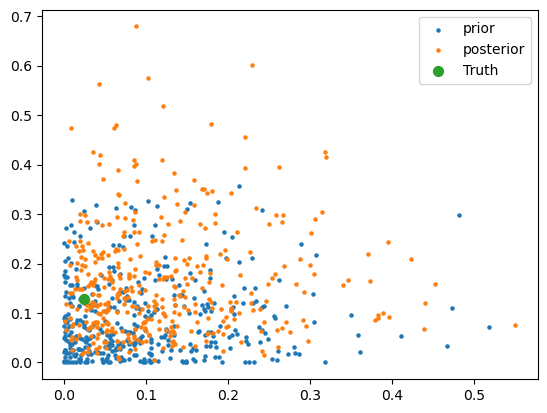

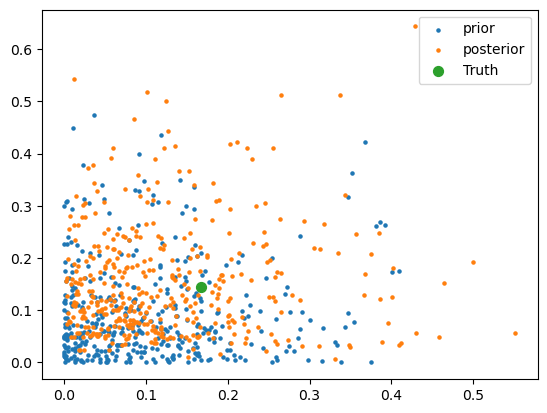

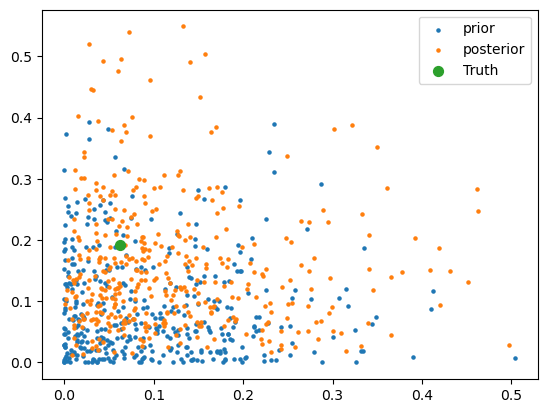

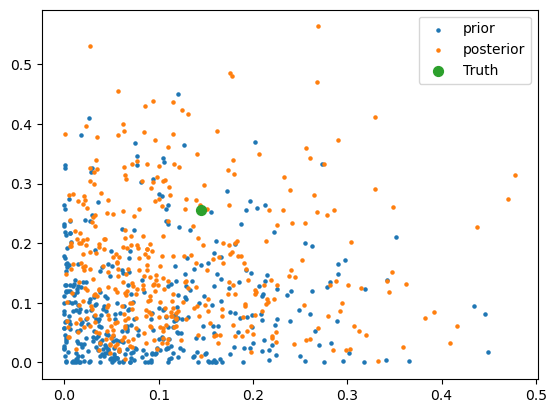

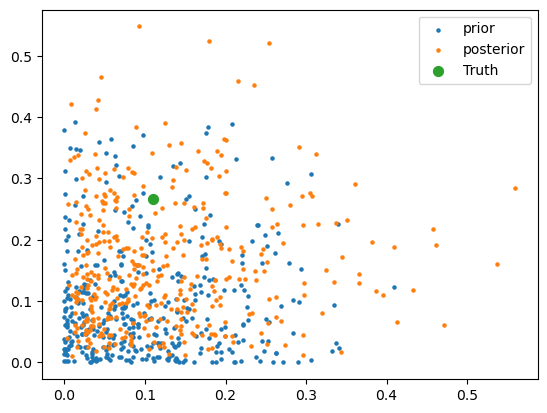

In [11]:
param1 = "infection_rate"
param2 = "recovery_rate"
obs_id = 2



for obs_id in range(5):

    plt.scatter(
        joint_samples[param1][:, obs_id],
        joint_samples[param2][:, obs_id],
        label="prior",
        s=5,
    )

    plt.scatter(
        posterior[param1][:, obs_id],
        posterior[param2][:, obs_id],
        label="posterior",
        s=5,
    )


    plt.scatter(
        true_latents[param1][obs_id],
        true_latents[param2][obs_id],
        label="Truth",
        s=50,
    )

    plt.legend()
    plt.show()


## Global inference

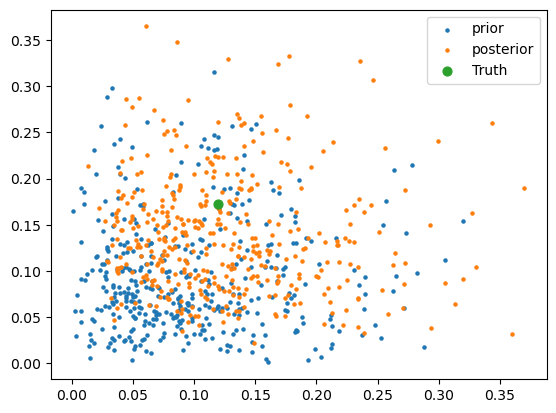

In [12]:
param1 = "infection_rate_mean"
param2 = "recovery_rate_mean"
obs_id = 1

plt.scatter(
    joint_samples[param1],
    joint_samples[param2],
    label="prior",
    s=5,
)

plt.scatter(
    posterior[param1],
    posterior[param2],
    label="posterior",
    s=5,
)


plt.scatter(
    true_latents[param1],
    true_latents[param2],
    label="Truth",
    s=40,
)

plt.legend()



In [15]:
from numpyro.infer.inspect import get_model_relations
relations = get_model_relations(
    model, model_kwargs={"use_surrogate": True},
    )["sample_sample"]
local_param_names = relations["x"]
site_names = model.site_names(use_surrogate=True)
global_param_names =  [name for name in site_names.latent if name.endswith("_mean")]

In [16]:
import seaborn as sns
import pandas as pd
data = {
    "prior": joint_samples,
    "posterior": posterior,
    "truth": true_latents,
}

dfs = []
for source, dataset in data.items():
    df = pd.DataFrame({k: dataset[k] for k in global_param_names})
    df["source"] = source
    dfs.append(df)

df = pd.concat(dfs)
sns.pairplot(df, hue="source")
    



ValueError: If using all scalar values, you must pass an index

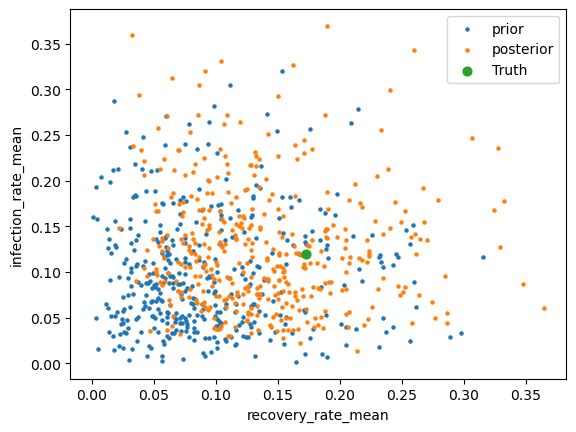

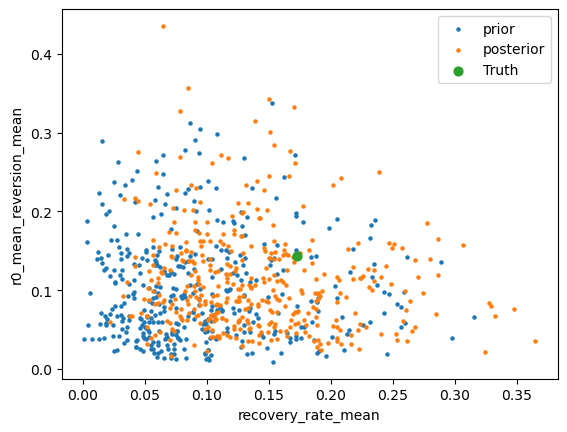

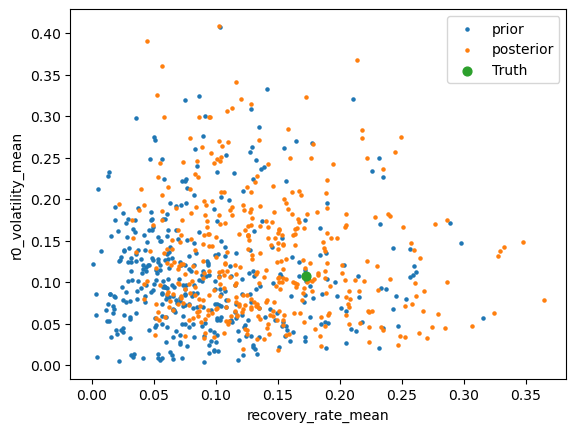

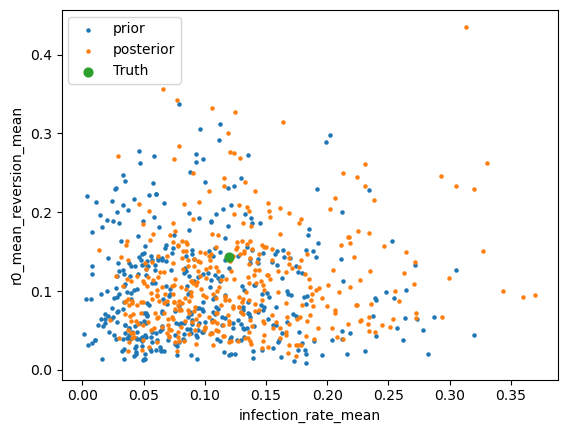

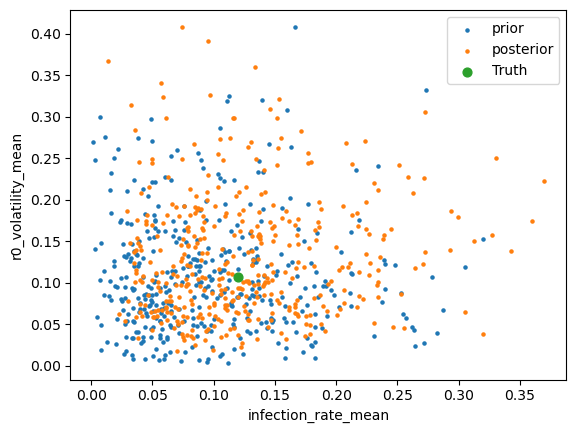

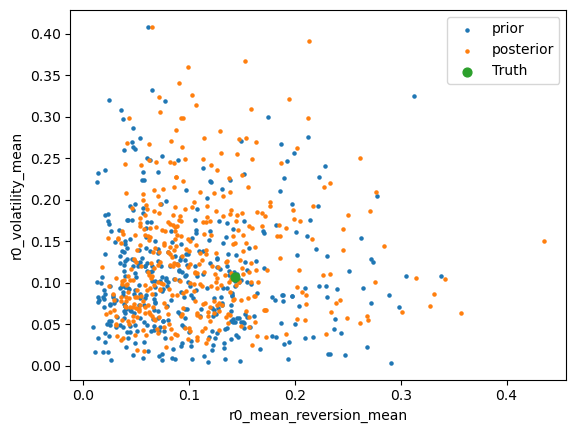

In [17]:
import itertools

for param1, param2 in itertools.combinations(global_param_names, 2):

    plt.scatter(
        joint_samples[param1],
        joint_samples[param2],
        label="prior",
        s=5,
    )

    plt.scatter(
        posterior[param1],
        posterior[param2],
        label="posterior",
        s=5,
    )


    plt.scatter(
        true_latents[param1],
        true_latents[param2],
        label="Truth",
        s=40,
    )
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.legend()
    plt.show()
    




In [28]:

from collections.abc import Iterable

import numpyro
from numpyro.infer.inspect import get_dependencies


def model_1():
    a = numpyro.sample("a", numpyro.distributions.Normal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.Normal(a, 1), obs=0.0)
    numpyro.sample("c", numpyro.distributions.Normal(b, 1), obs=1)



get_dependencies(model_1)

{'prior_dependencies': {'a': {'a': set()},
  'b': {'b': set(), 'a': set()},
  'c': {'c': set()}},
 'posterior_dependencies': {'a': {'a': set(), 'b': set()}}}